## Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
#from statsmodels.formula.api import ols
#from statsmodels.stats.anova import anova_lm
#import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [2]:
ObsData = pd.read_pickle('.\DataFrames\SoilVWC.pkl')
#ObsData.columns = ObsData.columns.droplevel([3,4,5,6,7,8,10])
#ObsData = ObsData.reorder_levels(['Depth','Irrigation','Nitrogen','Block'],axis=1)
ObsData.sort_index(axis=0,inplace=True)
ObsData.sort_index(axis=1,inplace=True)
#Set up factorLevel descriptors
Depths = ObsData.columns.get_level_values(0).drop_duplicates().values
F1 = ObsData.columns.get_level_values(1).drop_duplicates().values
F2 = ObsData.columns.get_level_values(2).drop_duplicates().values
Blocks = ObsData.columns.get_level_values(3).drop_duplicates().values
ObsData.loc['2021-12-13 05:00:00':'2021-12-13 17:00:00',:] =np.nan
ObsData.loc['2022-01-07 12:00:00':'2022-01-10 01:00:00',:] =np.nan

## Export top layer data for evaporation analysis

In [3]:
ObsData.loc[:,['D1B','D1I']].to_pickle('.\DataFrames\TopVWC.pkl')

In [4]:
GPs = GH.SetGraphicsPatterns(ObsData.D1B.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = ObsData.index.min()
End = ObsData.index.max()

Irrigation
['2D', '7D', '14D', '21D', 'MD', 'LD']
Species
['Peas']
Treatments
MultiIndex([( '2D', 'Peas'),
            ( '7D', 'Peas'),
            ('14D', 'Peas'),
            ('21D', 'Peas'),
            ( 'MD', 'Peas'),
            ( 'LD', 'Peas')],
           )
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
         Lin     Col   Alp Mar     MFC
2D  Peas   -  orange  0.15   o  orange
7D  Peas   -   green  0.15   o   white
14D Peas   -  purple  0.15   o   white
21D Peas  --  orange  0.45   ^   white
MD  Peas  --   green  0.45   ^   white
LD  Peas  --  purple  0.45   ^   white


In [5]:
ObsData=ObsData.where(ObsData<0.7)

<AxesSubplot:>

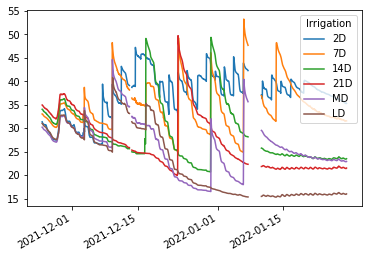

In [6]:
ObsData.loc[:,['D1B','D1I']].groupby('Irrigation',axis=1).mean().multiply(150).plot()

In [7]:
#Rough attempt to fill gaps with synth data failed
# def fillBlanks(v,t):
#     TreatMean = ObsData.loc[v,t[:3]].mean()
#     #yesterday = datetime.datetime.strftime(datetime.datetime.strptime(v,r'%Y-%m-%d %H:%M:%S') - datetime.timedelta(1),r'%Y-%m-%d %H:%M:%S')
#     yesterday = datetime.datetime.strftime(v - datetime.timedelta(1),r'%Y-%m-%d %H:%M:%S')
#     TreatMeanyesterday = ObsData.loc[yesterday:v,t[:3]].mean(axis=1)
#     treatvalsYesterday = ObsData.loc[yesterday:v,t]
#     offset = treatvalsYesterday/TreatMeanyesterday
#     synthVal = TreatMean * offset.mean()
#     return synthVal

# for t in ObsData.columns:
#     if ObsData.loc[:,t].isnull().any():
#         for v in ObsData.index:
#             if np.isnan(ObsData.loc[v,t]):
#                 ObsData.loc[v,t] = fillBlanks(v,t)

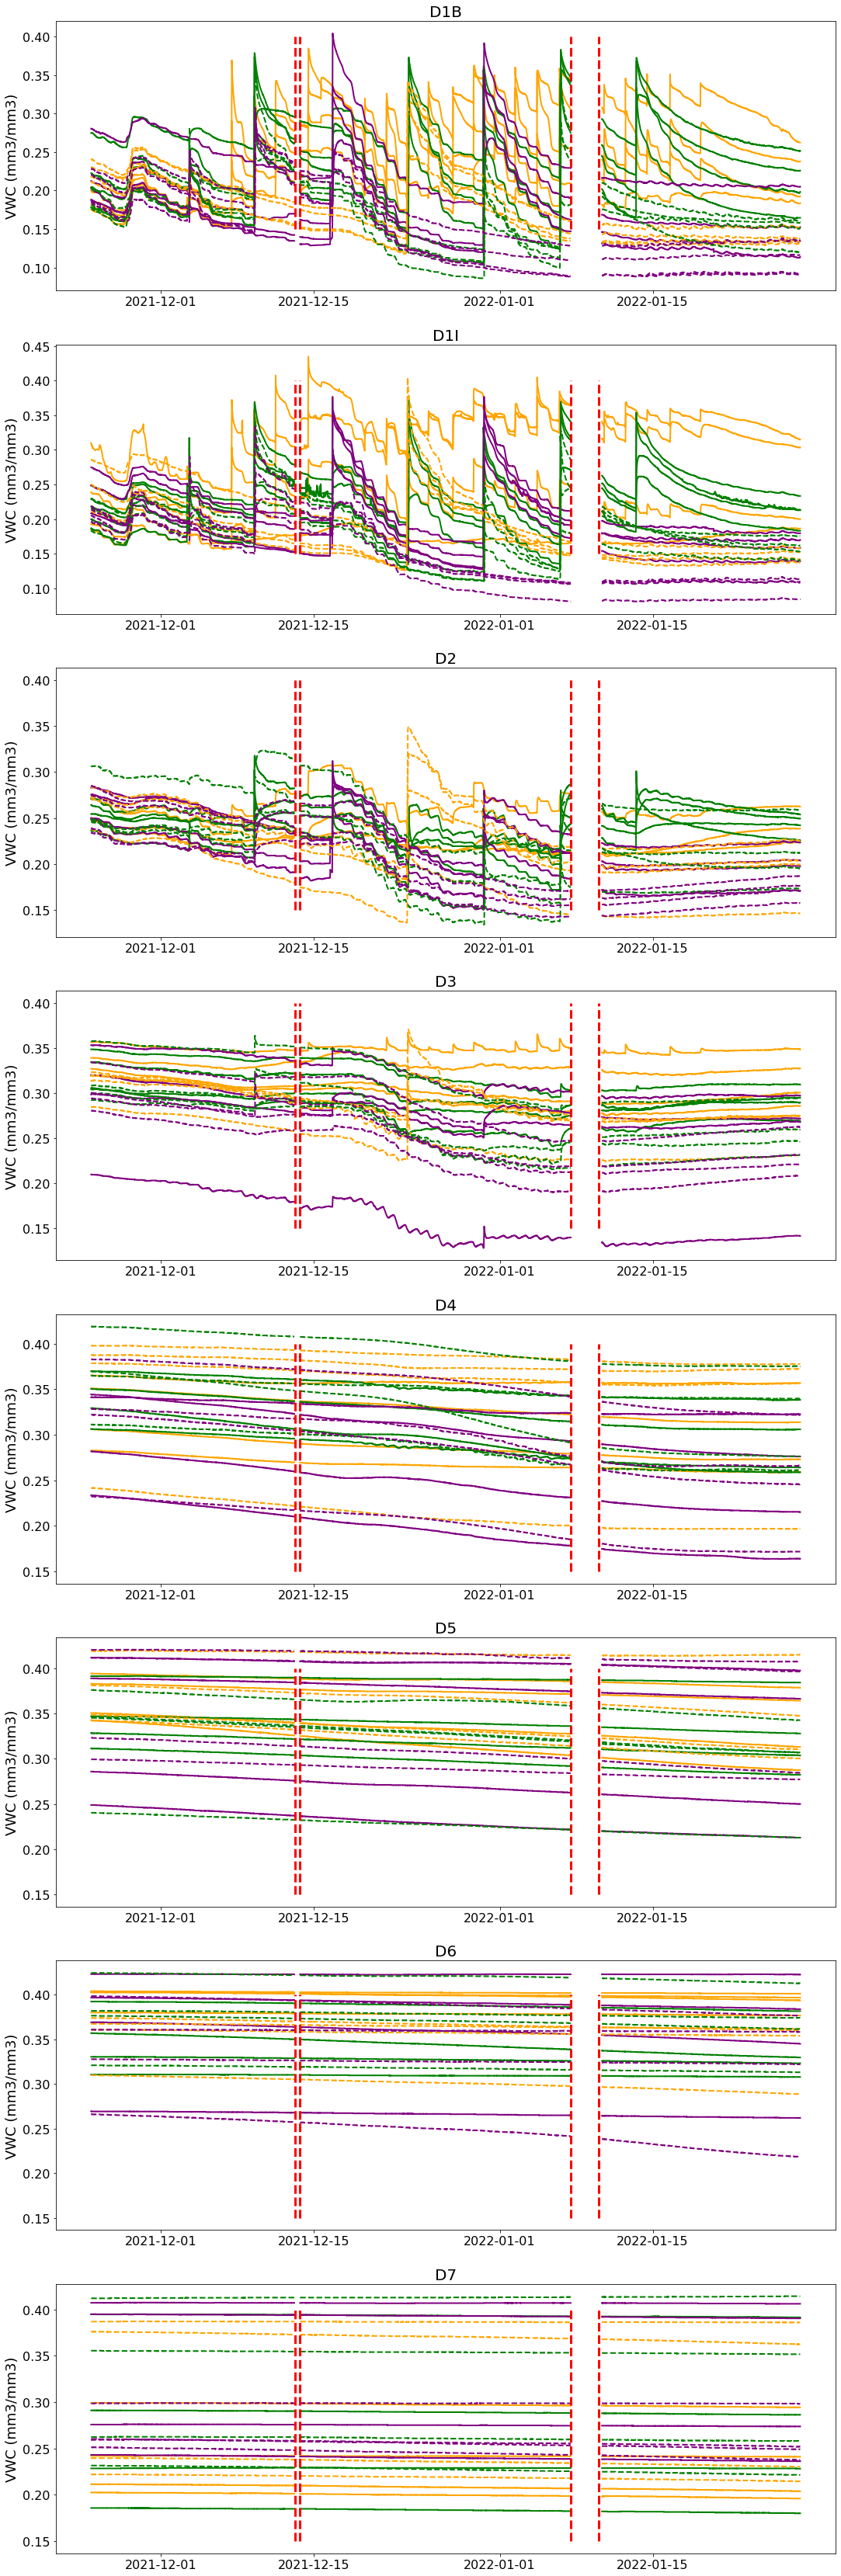

In [8]:
Graph = plt.figure(figsize=(18,60))
pos = 1
for D in Depths:
    ax = Graph.add_subplot(8,1,pos)
    GH.AddIndexedPlot(ObsData.loc[:,D],ax,GPs,2)
    plt.title(D,fontsize=20)
    plt.tick_params(labelsize=16)
    plt.ylabel('VWC (mm3/mm3)',fontsize=18)
    plt.plot([datetime.datetime.strptime('2021-12-13 06:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.15,.40],'--',color='red',lw=3)
    plt.plot([datetime.datetime.strptime('2021-12-13 16:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.15,.40],'--',color='red',lw=3)
    plt.plot([datetime.datetime.strptime('2022-01-07 12:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.15,.40],'--',color='red',lw=3)
    plt.plot([datetime.datetime.strptime('2022-01-10 01:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.15,.40],'--',color='red',lw=3)
    pos +=1

## Calculate soil water deficit

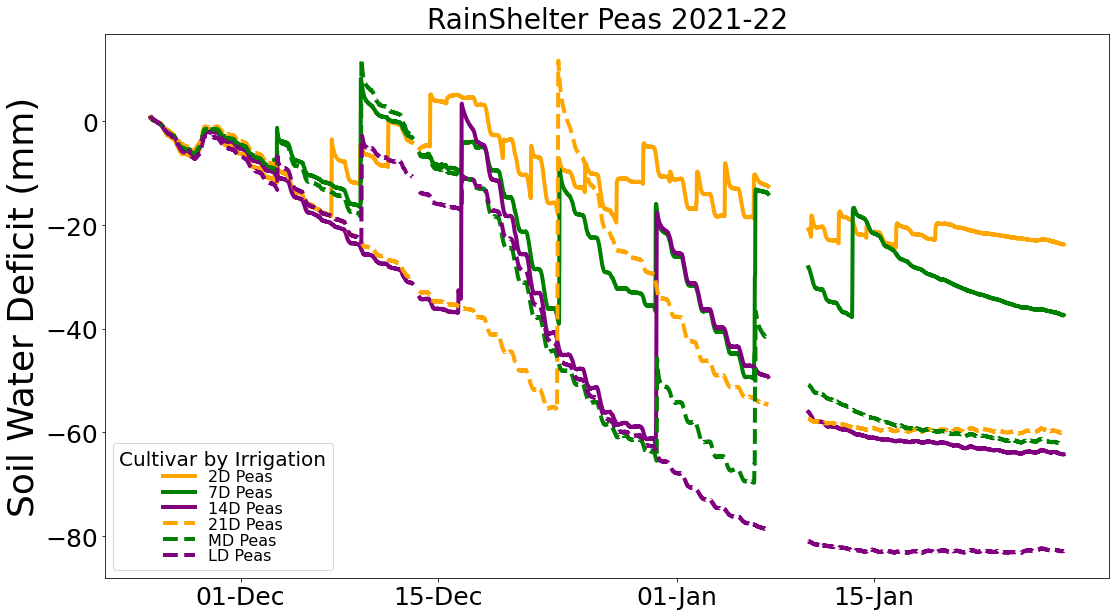

In [9]:
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  ObsData.groupby(level=['Depth','Irrigation', 'Species'],axis=1).mean()

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.loc[:,'D1I'] * 150/2 + \
               DataMeans.loc[:,'D1B'] * 150/2 + \
               DataMeans.loc[:,'D2'] * 150 + \
               DataMeans.loc[:,'D3'] * 300 + \
               DataMeans.loc[:,'D4'] * 300 + \
               DataMeans.loc[:,'D5'] * 300 + \
               DataMeans.loc[:,'D6'] * 300 + \
               DataMeans.loc[:,'D7'] * 300
                
FieldCapacity = ProfileWater.resample('D').max()
FieldCapacity = FieldCapacity.loc['2021-11-25']   # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater.loc['2021-11-18':,:])    # This calculation only works because field capacity is a multi index series
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(SoilWaterDeficit,ax,GPs,4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Peas 2021-22', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

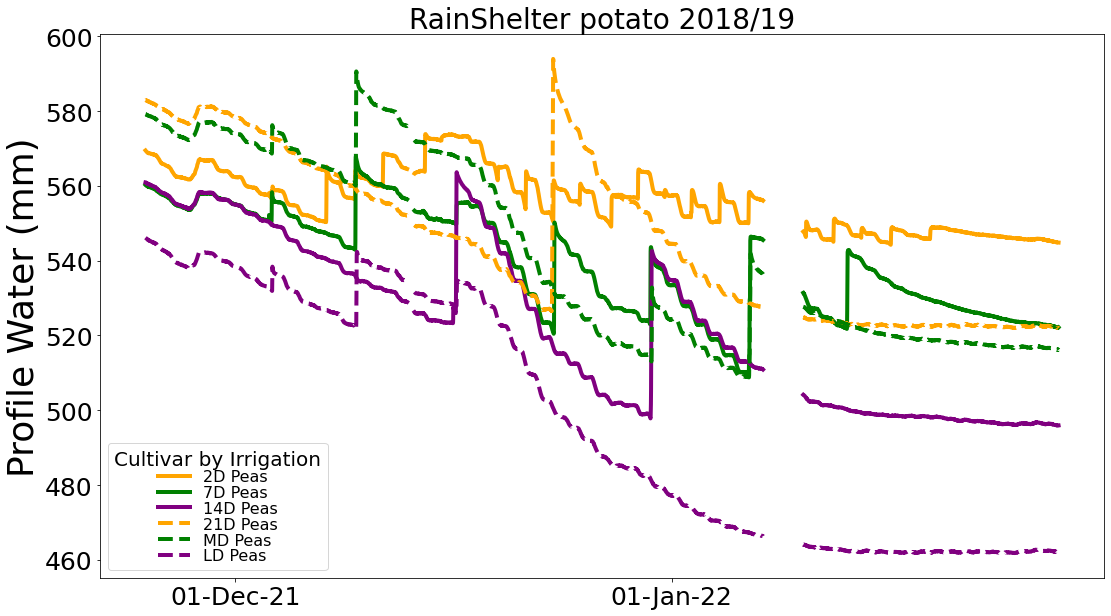

In [10]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(ProfileWater,ax,GPs,4)
plt.ylabel('Profile Water (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter potato 2018/19', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


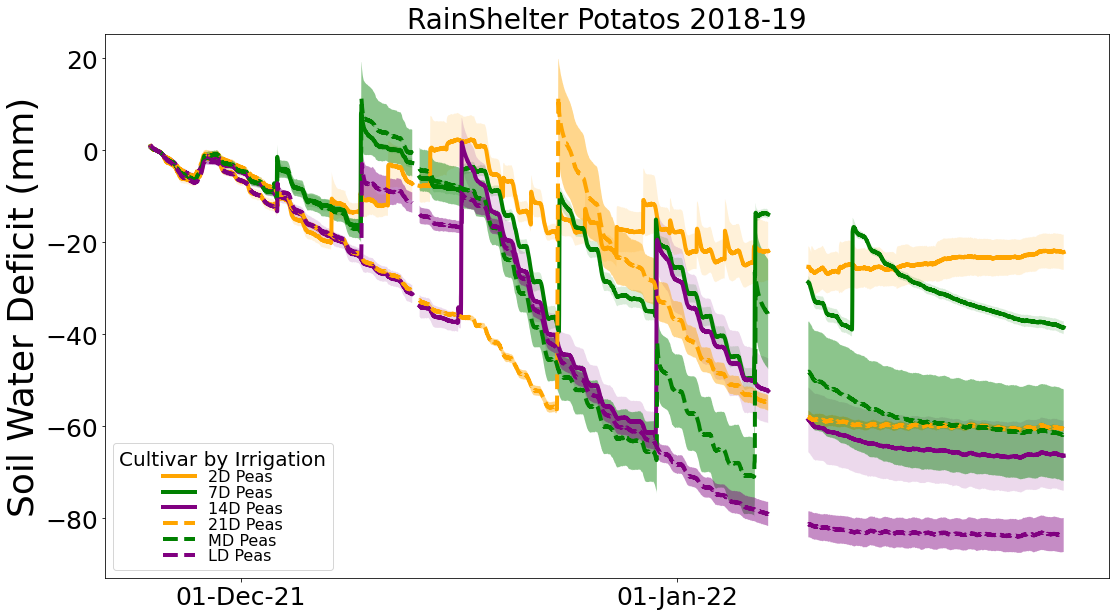

In [11]:
DataMeans2 = ObsData.groupby(level=['Depth', 'Irrigation', 'Species','Block'],axis=1).mean()
DataMeans2 =  DataMeans2.dropna(axis=1, how = 'all')

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater2 = DataMeans2.loc[:,'D1I'] * 150/2 + \
               DataMeans2.loc[:,'D1B'] *150/2 + \
               DataMeans2.loc[:,'D2'] * 150 + \
               DataMeans2.loc[:,'D3'] * 300 + \
               DataMeans2.loc[:,'D4'] * 300 + \
               DataMeans2.loc[:,'D5'] * 300 + \
               DataMeans2.loc[:,'D6'] * 300 + \
               DataMeans2.loc[:,'D7'] * 300
                
FieldCapacity2 = ProfileWater2.resample('D').max()
FieldCapacity2 = FieldCapacity2.loc['2021-11-25'] 
SoilWaterDeficit2 = -(FieldCapacity2 - ProfileWater2.loc[:,:])

Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlotWithSEM(SoilWaterDeficit2,ax,GPs,4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Potatos 2018-19', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

In [12]:
FinalSWD = SoilWaterDeficit2.loc['2022-01-27',:].mean(axis=0)

In [13]:
FinalSWD.to_excel('FinalSWD.xlsx')

In [14]:
DeltaWater = ProfileWater2.diff()
DeltaWater.to_pickle('.\DataFrames\ProfileWaterDelta.pkl')
SWD = SoilWaterDeficit.resample('D').mean()
SWD.to_pickle('.\DataFrames\DailySWD.pkl')

In [15]:
DailyDeltaWater = DeltaWater.resample('d').sum().resample('d').sum()
DailyDeltaWater.where(DailyDeltaWater<2,np.nan,inplace=True)
DailyDeltaWater.to_pickle('.\DataFrames\DailyWU.pkl')

In [16]:
list(ObsData.columns.get_level_values(0).drop_duplicates().values)

['D1B', 'D1I', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']

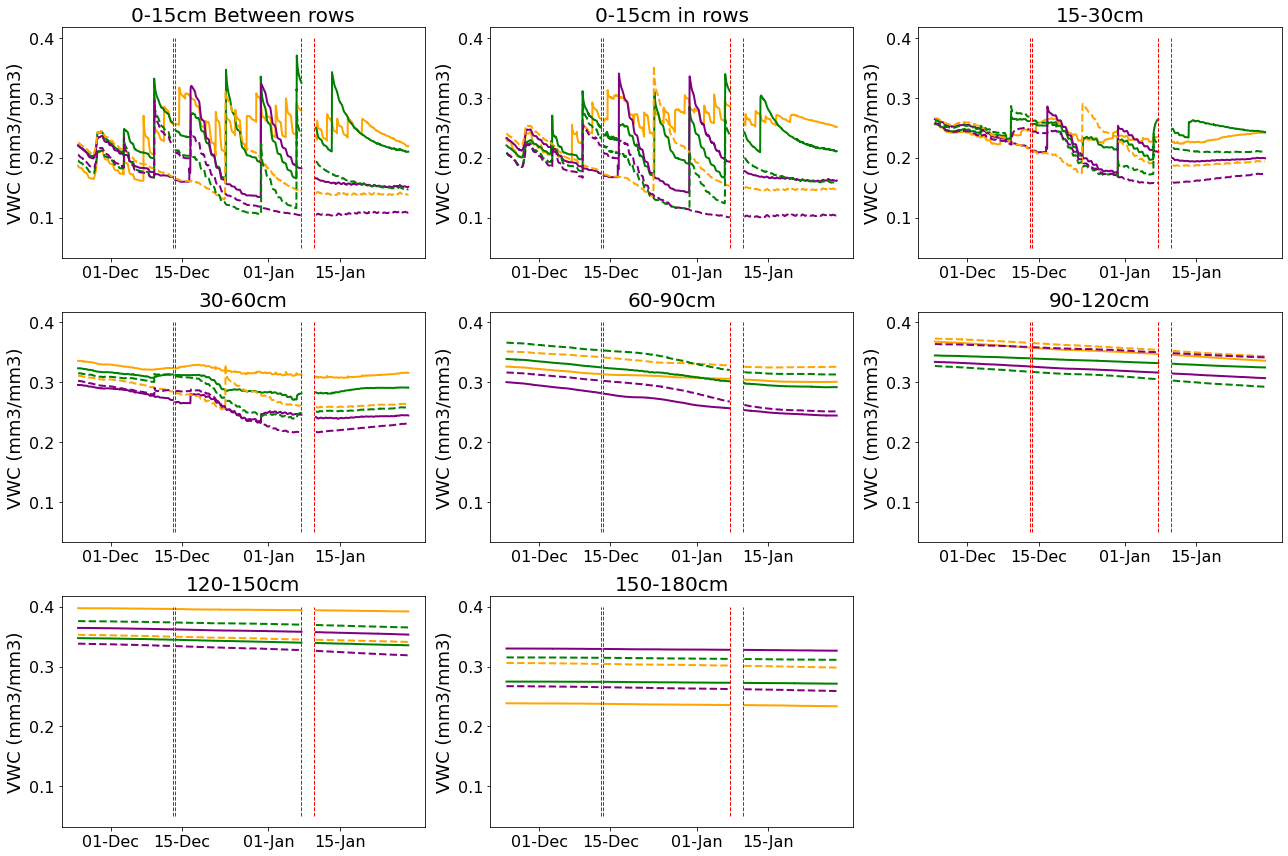

In [17]:
depthTits = pd.Series(index = ['D1B', 'D1I', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7'],
                      data = ['0-15cm Between rows', '0-15cm in rows', '15-30cm', '30-60cm', '60-90cm', '90-120cm', '120-150cm', '150-180cm'])
Graph = plt.figure(figsize=(18,12))
pos = 1
for D in Depths:
    ax = Graph.add_subplot(3,3,pos)
    GH.AddIndexedPlot(ObsData.loc[:,D].groupby(by=['Irrigation','Species'],axis=1).mean(),ax,GPs,2)
    plt.title(depthTits[D],fontsize=20)
    plt.tick_params(labelsize=16)
    plt.ylabel('VWC (mm3/mm3)',fontsize=18)
    plt.plot([datetime.datetime.strptime('2021-12-13 06:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.05,.40],'--',color='red',lw=1)
    plt.plot([datetime.datetime.strptime('2021-12-13 16:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.05,.40],'--',color='red',lw=1)
    plt.plot([datetime.datetime.strptime('2022-01-07 12:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.05,.40],'--',color='red',lw=1)
    plt.plot([datetime.datetime.strptime('2022-01-10 01:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.05,.40],'--',color='red',lw=1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    pos +=1
plt.tight_layout()

In [18]:
Depths

array(['D1B', 'D1I', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7'], dtype=object)

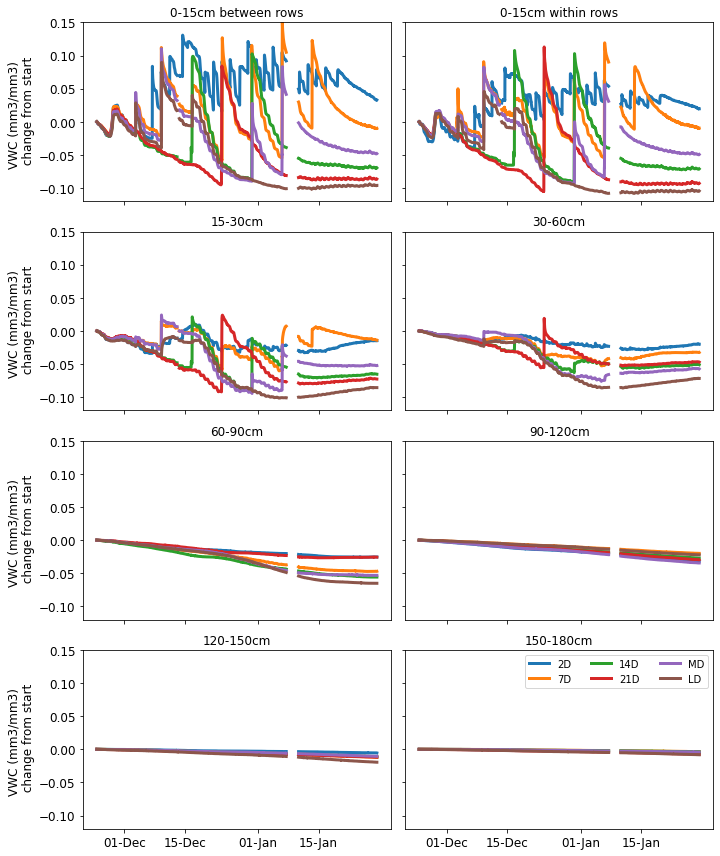

In [19]:
RelativeWaterContent = ObsData.groupby(by=['Depth','Irrigation','Species'],axis=1).mean()-ObsData.groupby(by=['Depth','Irrigation','Species'],axis=1).mean().iloc[0,:]
Treats = ['2D','7D', '14D','21D', 'MD','LD']
depthTits = pd.Series(index = ['D1B', 'D1I', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7'],
                      data = ['0-15cm between rows', '0-15cm within rows', '15-30cm', '30-60cm', '60-90cm', '90-120cm', '120-150cm', '150-180cm'])
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
Graph = plt.figure(figsize=(10,12))
pos = 1
for D in Depths:
    ax = Graph.add_subplot(4,2,pos)
    tpos=0
    for t in Treats:
        plt.plot(RelativeWaterContent.loc[:,(D,t)],color=colors[tpos],lw=3,label=t)
        tpos+=1
    plt.ylim(-0.12,0.15)
    plt.title(depthTits[D],fontsize=12)
    plt.tick_params(labelsize=12)
    if D in ['D1B', 'D2', 'D4', 'D6']:
        plt.ylabel('VWC (mm3/mm3) \n change from start',fontsize=12)
    else:
         ax.set_yticklabels([])
    if D in ['D6','D7']:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    else:
        ax.set_xticklabels([])
    pos+=1
plt.legend(ncol=3)
plt.tight_layout()

<AxesSubplot:>

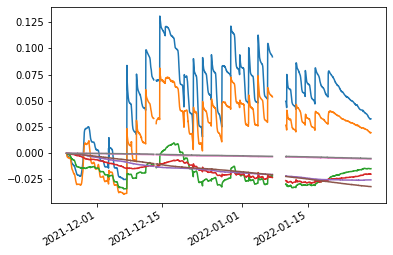

In [20]:
RelativeWaterContent.loc[:,(slice(None),'2D')].plot(legend=False)

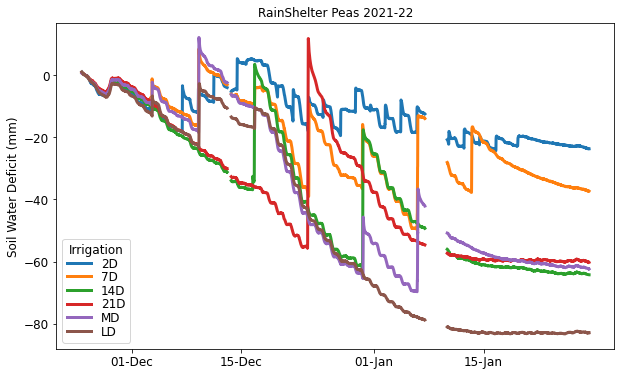

In [21]:
Graph = plt.figure(figsize=(10,6))
ax = Graph.add_subplot(1,1,1)
tpos=0
for t in Treats:
    plt.plot(SoilWaterDeficit.loc[:,t],color=colors[tpos],label=t,lw=3)
    tpos+=1
plt.ylabel('Soil Water Deficit (mm)', fontsize=12);
plt.tick_params(labelsize=12)
plt.title('RainShelter Peas 2021-22', fontsize=12);
plt.legend(fontsize=12, loc=3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 12,labelspacing = 0.05, 
                          title='Irrigation')
ledg.get_title().set_fontsize(12)

In [22]:
SoilWaterDeficit.iloc[-1,:]

Irrigation  Species
2D          Peas      -23.740000
7D          Peas      -37.365000
14D         Peas      -64.243125
21D         Peas      -60.226875
MD          Peas      -62.351250
LD          Peas      -82.863750
Name: 2022-01-28 11:45:00, dtype: float64

In [23]:
Applications = pd.read_pickle('IrrigApplications.pkl')

In [24]:
Applications.index = pd.to_datetime(Applications.index)

In [25]:
E = pd.read_pickle('E_IR_accum.pkl')

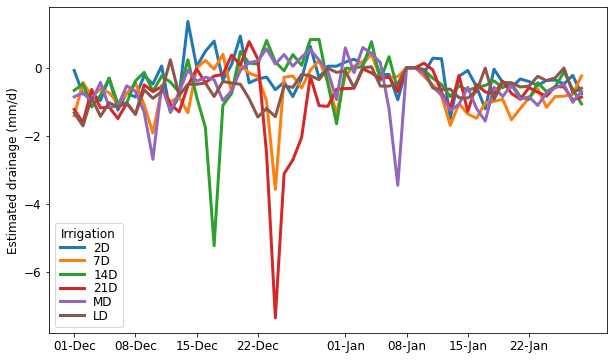

In [26]:
WaterDelta = ProfileWater.diff()
DarkWaterDeltas = WaterDelta.iloc[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(4))]
DarkWaterDeltas = DarkWaterDeltas.resample('24H', offset=5).sum()#Offset of 5 means sampling from 6am to 6am
MeanDarkWaterDeltas = DarkWaterDeltas.groupby(level=['Irrigation','Species'],axis=1).mean()
drainage = MeanDarkWaterDeltas.loc['2021-12-1':,:]*4.8
Graph = plt.figure(figsize=(10,6))
ax = Graph.add_subplot(1,1,1)
tpos=0
for t in Treats:
    plt.plot(drainage.loc[:,t],color=colors[tpos],label=t,lw=3)
    tpos+=1
plt.ylabel('Estimated drainage (mm/d)', fontsize=12);
plt.tick_params(labelsize=12)
#plt.title('RainShelter Peas 2021-22', fontsize=12);
plt.legend(fontsize=12, loc=3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 12,labelspacing = 0.05, 
                          title='Irrigation')
ledg.get_title().set_fontsize(12)

In [27]:
drainage.index = drainage.index.date

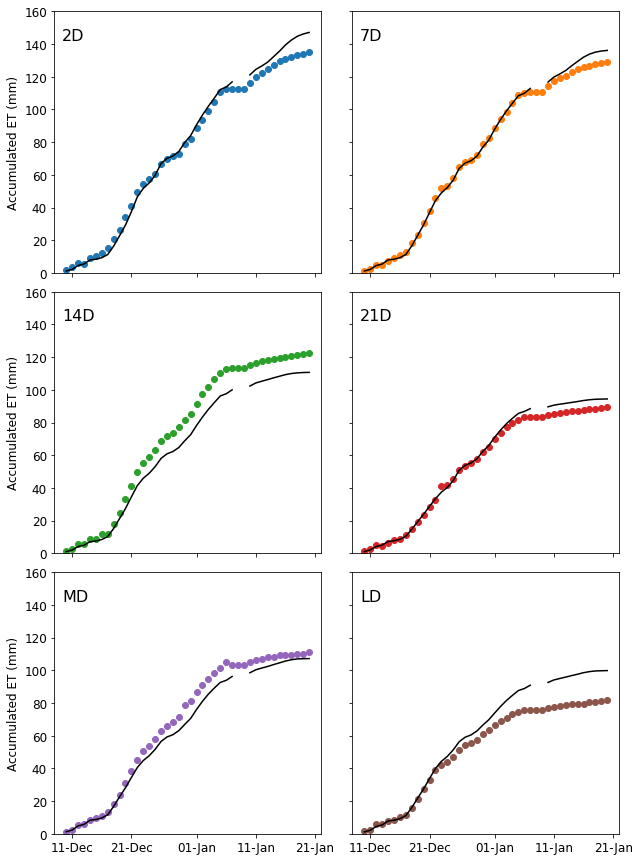

In [28]:
Graph = plt.figure(figsize=(9,12))
tpos=0
pos=1
for t in Treats:
    ax = Graph.add_subplot(3,2,pos)
    WU = SoilWaterDeficit.loc['2021-12-10':'2022-1-20',t].diff()
    WU = WU.where(WU<0.).resample('d').sum()
    ET = WU - drainage.loc[datetime.date(2021,12,10):datetime.date(2022,1,20),t]
    plt.plot(-ET.cumsum(),'o',color=colors[tpos],label=t,lw=3)
    plt.plot(E.loc['2021-12-10':'2022-1-20',t].cumsum(),'-',color='k')
    plt.ylim(0,160)
    tpos+=1
    pos+=1
    if t in ['2D','14D','MD']:
        plt.ylabel('Accumulated ET (mm)', fontsize=12);
    else:
        ax.set_yticklabels([])
    plt.tick_params(labelsize=12)
    #plt.title('RainShelter Peas 2021-22', fontsize=12);
    #plt.legend(fontsize=12, loc=3)
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,11,21]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    if t in ['MD','LD']:
        do = 'nothing'
    else:
        ax.set_xticklabels([])
    plt.text(0.03,0.89,t,transform=ax.transAxes,fontsize=16)
plt.tight_layout()
#ledg = plt.legend(loc=3,numpoints=1,fontsize = 12,labelspacing = 0.05, 
#                          title='Irrigation')
#ledg.get_title().set_fontsize(12)

In [29]:
met  = pd.read_pickle('C:\GitHubRepos\Weather\Broadfields\BroadFieldsDaily.pkl')

In [30]:
met.loc['2021-11-20':'2022-01-20','Rain'].sum()

160.00000000000003